# imports

In [33]:
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
import datetime

from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
sns.set(style="darkgrid")



from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import ParameterGrid

In [2]:
co2_df = pd.read_csv('data/co2_concentration_df.csv')

In [3]:
co2_df['datetime'] = co2_df['datetime'].apply(lambda x : datetime.datetime.strptime(x, '%Y-%m-%d'))
co2_df.set_index('datetime', inplace=True)

## treating data

In [4]:
co2_diff = pd.DataFrame(co2_df['data_mean_global'].diff(1))

In [5]:
co2_diff.dropna(inplace=True)

In [6]:
co2_diff

,data_mean_global
datetime,
1677-11-15,1.004565
1677-12-15,0.637296
1678-01-15,0.460474
1678-02-15,0.383064
1678-03-15,0.341987
...,...
2014-08-15,-1.075374
2014-09-15,0.453349
2014-10-15,1.641950


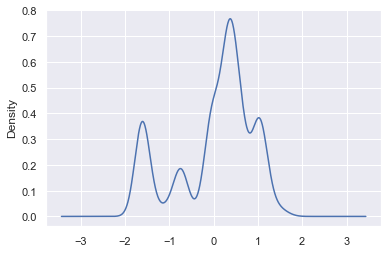

In [7]:
co2_diff['data_mean_global'].plot(kind='kde')

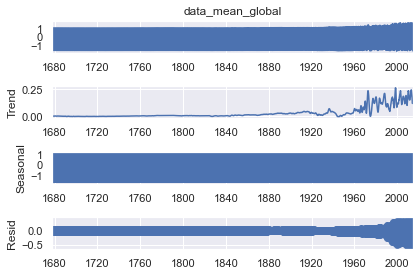

In [8]:
s_decomp = seasonal_decompose(co2_diff['data_mean_global'], model='additive', period=12)
s_decomp.plot()
plt.show()

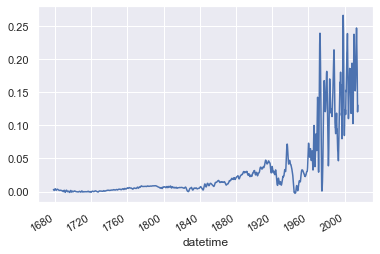

In [9]:
s_decomp.trend.plot()



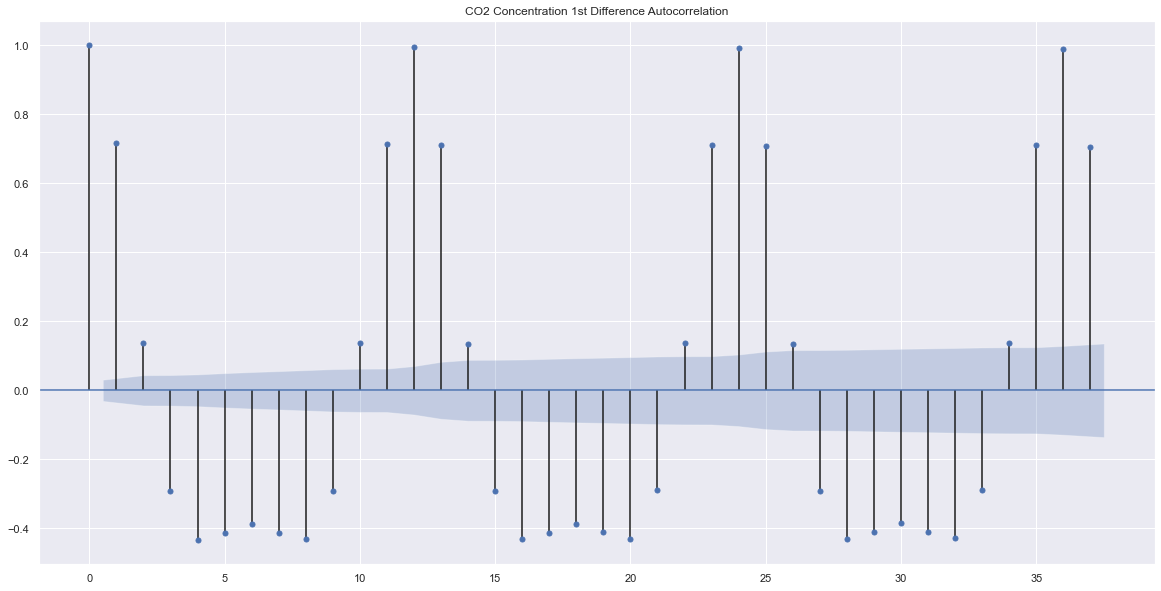

In [10]:
fig, ax = plt.subplots(figsize=(20,10))

ax = plot_acf(co2_diff['data_mean_global'], ax, title='CO2 Concentration 1st Difference Autocorrelation')

plt.show()

## creating lagged DF

In [11]:
lagged_df = pd.DataFrame()

In [12]:
for i in range(12, 0, -1):
    lagged_df[['t-' + str(i)]] = co2_diff.shift(i)

lagged_df['t'] = co2_diff['data_mean_global']

In [13]:
lagged_df

,t-12,t-11,t-10,t-9,t-8,t-7,t-6,t-5,t-4,t-3,t-2,t-1,t
datetime,,,,,,,,,,,,,
1677-11-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.004565
1677-12-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.004565,0.637296
1678-01-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.004565,0.637296,0.460474
1678-02-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.004565,0.637296,0.460474,0.383064
1678-03-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.004565,0.637296,0.460474,0.383064,0.341987
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-08-15,-1.054752,0.459491,1.601446,1.466388,0.933017,0.820863,0.380413,0.229407,0.074560,-0.470685,-1.286312,-1.688781,-1.075374
2014-09-15,0.459491,1.601446,1.466388,0.933017,0.820863,0.380413,0.229407,0.074560,-0.470685,-1.286312,-1.688781,-1.075374,0.453349
2014-10-15,1.601446,1.466388,0.933017,0.820863,0.380413,0.229407,0.074560,-0.470685,-1.286312,-1.688781,-1.075374,0.453349,1.641950


In [14]:
lagged_df.dropna(axis=0, inplace=True)

### features and target

In [15]:
X = lagged_df.iloc[:, :-1].values
y = lagged_df.iloc[:, -1:].values

In [16]:
train_size = int(len(X) * 0.8)

In [17]:
X_train, X_test, y_train, y_test = X[0:train_size], X[train_size:len(X)], y[0:train_size], y[train_size:len(X)]

print('train size ' +str(len(X_train) ))
print('test size ' +str(len(X_test) ))

train size 3227
test size 807


## Decicion Tree

does not work well with data w trend

In [18]:
dt = DecisionTreeRegressor(max_depth= 4)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=4)

In [19]:
dt.score(X_train, y_train)

0.9988456044763335

In [20]:
dt.score(X_test, y_test)

0.7412364448872696

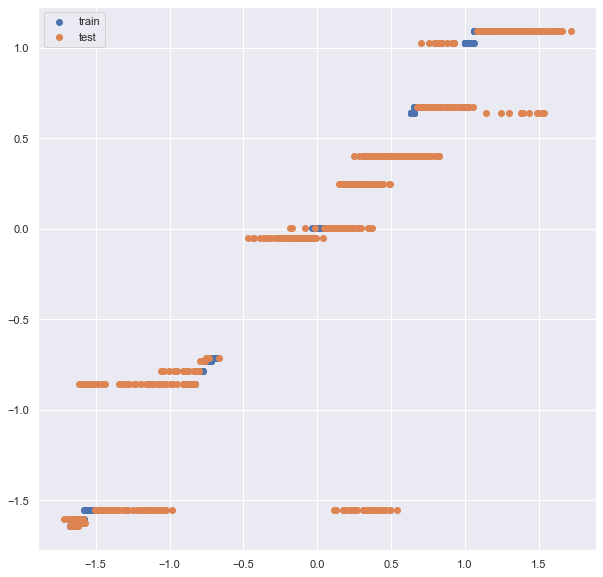

In [21]:
plt.subplots(figsize=(10,10))

# making predictions
train_prediction = dt.predict(X_train)
test_prediction = dt.predict(X_test)


# scatter with predictions and actual values
plt.scatter(y_train, train_prediction, label='train')
plt.scatter(y_test, test_prediction, label='test')
plt.legend()
plt.show()

## Random Forest

In [22]:
rfr = RandomForestRegressor(n_estimators=200)
rfr.fit(X_train, y_train.ravel())

RandomForestRegressor(n_estimators=200)

In [23]:
rfr.score(X_train, y_train)

0.9999982812182007

In [24]:
rfr.score(X_test, y_test)

0.9053387139580532

### grid search

In [25]:
grid = {'n_estimators': [50, 100, 200], 'max_depth': {3, 5, 7}, 'max_features': [2,3,4,5,6,7,8,9,10,11,12], 'random_state': [42]}
test_scores = []

In [26]:
for g in ParameterGrid(grid):
    rfr.set_params(**g)
    rfr.fit(X_train, y_train.ravel())
    test_scores.append(rfr.score(X_test, y_test))

In [27]:
best_score_index = np.argmax(test_scores)
best_score_index

70

In [28]:
index = 0
best_grid = dict()
for g in ParameterGrid(grid):
    if(best_score_index == index):
        print(g)
        best_grid = g
    index = index + 1



{'max_depth': 7, 'max_features': 3, 'n_estimators': 100, 'random_state': 42}


In [29]:
print(test_scores[best_score_index], best_grid)

0.9327267907290069 {'max_depth': 7, 'max_features': 3, 'n_estimators': 100, 'random_state': 42}


In [30]:
rfr.set_params(**best_grid)
rfr.fit(X_train, y_train.ravel())

RandomForestRegressor(max_depth=7, max_features=3, random_state=42)

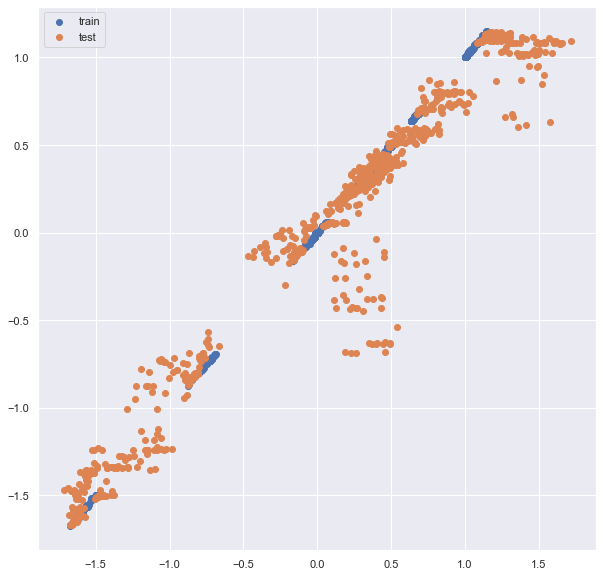

In [31]:
plt.subplots(figsize=(10,10))

# making predictions
train_prediction = rfr.predict(X_train)
test_prediction = rfr.predict(X_test)

# scatter with predictions and actual values
plt.scatter(y_train, train_prediction, label='train')
plt.scatter(y_test, test_prediction, label='test')
plt.legend()
plt.show()

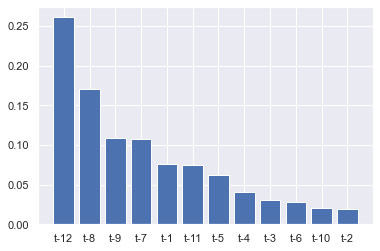

In [32]:
# importances of each feature in the model
importances = rfr.feature_importances_

# sort index by importances
sorted_index = np.argsort(importances)[::-1]
x = range(len(importances))

# label names
names = ['t-12','t-11','t-10','t-9','t-8','t-7','t-6','t-5','t-4','t-3','t-2','t-1']
# labels to importances
labels = np.array(names)[sorted_index]

plt.bar(x, importances[sorted_index], tick_label=labels)

plt.show()

## gradient boost tree regressor

In [35]:
gbr = GradientBoostingRegressor(max_features=2, learning_rate=0.01, n_estimators=50, subsample=0.6, random_state=42)

In [38]:
gbr.fit(X_train, y_train.ravel())

GradientBoostingRegressor(learning_rate=0.01, max_features=2, n_estimators=50,
                          random_state=42, subsample=0.6)

In [39]:
gbr.score(X_train, y_train)

0.6251547127239541

In [40]:
gbr.score(X_test, y_test)

0.5273245708768155

### grid search

In [41]:
grid = {'n_estimators': [50, 100, 200], 'max_depth': {3, 5, 7}, 'max_features': [2,3,4,5,6,7,8,9,10,11,12], 'learning_rate': [0.6,0.7,0.8,0.9], 'learning_rate': [0.01, 0.005, 0.02, 0.05, 0.1] ,'random_state': [42]}
test_scores = []

In [42]:
for g in ParameterGrid(grid):
    gbr.set_params(**g)
    gbr.fit(X_train, y_train.ravel())
    test_scores.append(rfr.score(X_test, y_test))

In [43]:
best_score_index = np.argmax(test_scores)

index = 0
best_grid = dict()
for g in ParameterGrid(grid):
    if(best_score_index == index):
        print(g)
        best_grid = g
    index = index + 1

print(test_scores[best_score_index], best_grid)

{'learning_rate': 0.01, 'max_depth': 3, 'max_features': 2, 'n_estimators': 50, 'random_state': 42}
0.9327267907290069 {'learning_rate': 0.01, 'max_depth': 3, 'max_features': 2, 'n_estimators': 50, 'random_state': 42}


In [44]:
gbr.set_params(**best_grid)
gbr.fit(X_train, y_train.ravel())

GradientBoostingRegressor(learning_rate=0.01, max_features=2, n_estimators=50,
                          random_state=42, subsample=0.6)

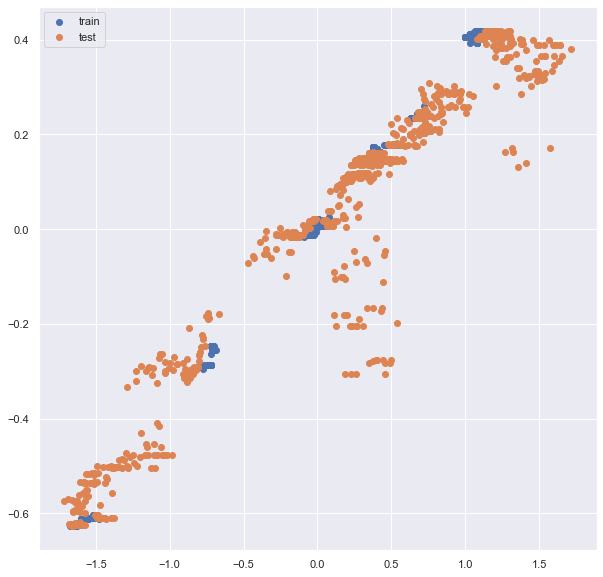

In [45]:
plt.subplots(figsize=(10,10))

# making predictions
train_prediction = gbr.predict(X_train)
test_prediction = gbr.predict(X_test)

# scatter with predictions and actual values
plt.scatter(y_train, train_prediction, label='train')
plt.scatter(y_test, test_prediction, label='test')
plt.legend()
plt.show()

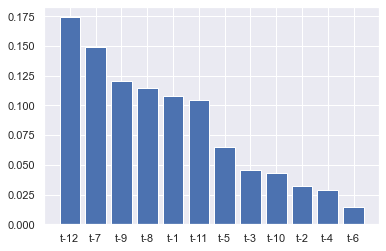

In [46]:
# importances of each feature in the model
importances = gbr.feature_importances_

# sort index by importances
sorted_index = np.argsort(importances)[::-1]
x = range(len(importances))

# label names
names = ['t-12','t-11','t-10','t-9','t-8','t-7','t-6','t-5','t-4','t-3','t-2','t-1']
# labels to importances
labels = np.array(names)[sorted_index]

plt.bar(x, importances[sorted_index], tick_label=labels)

plt.show()